In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
scaled_test_X=pd.read_csv('/Users/cheriehe/scaled_test_X.csv')
scaled_test_X.drop(columns=['Unnamed: 0'], inplace=True)
scaled_train_X=pd.read_csv('/Users/cheriehe/scaled_train_X.csv')
train_y=pd.read_csv('/Users/cheriehe/train_y.csv')
scaled_train_X.drop(columns=['Unnamed: 0'], inplace=True)
train_y.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import xgboost as xgb

OSError: dlopen(/Users/cheriehe/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/cheriehe/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

In [15]:
train_y=train_y['time_to_failure']

In [19]:
def xgb_evaluate(max_depth, subsample,gamma, colsample_bytree, max_leaves,max_bin, min_child_weight,colsample_bylevel,\
                reg_alpha,reg_lambda):
    params = {'eval_metric': 'rmse',\
              'objective': 'reg:linear',\
              'booster':'gbtree',\
              'max_depth': int(max_depth),\
              'subsample': subsample,\
              'eta': 0.03,\
              'gamma': gamma,\
              'colsample_bytree': colsample_bytree,\
             'max_leaves': int(max_leaves),\
              'max_bin':int(max_bin),\
              'min_child_weight':min_child_weight,\
              'colsample_bylevel':colsample_bylevel,\
              'reg_alpha':reg_alpha,\
              'reg_lambda':reg_lambda}
    cv_result = xgb.cv(params, dtrain, num_boost_round=20000, nfold=5)    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [20]:
dtrain = xgb.DMatrix(scaled_train_X, label=train_y)
dtest = xgb.DMatrix(scaled_test_X)

In [21]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (-1, 8), \
                                             'gamma': (0, 1),\
                                             'subsample': (0.6, 1.0),\
                                            'max_leaves': (20, 80),\
                                            'colsample_bytree': (0.6, 1.0),\
                                            'reg_lambda': (0, 1),\
                                            'reg_alpha': (0, 1),\
                                            'max_bin':(180,500),\
                                            'colsample_bylevel':(0.6,1.0),\
                                            'min_child_weight': (3, 20)})
# Use the expected improvement acquisition function to handle negative numbers
xgb_bo.maximize(init_points=2, n_iter=8, acq='ei')

Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bylevel |   colsample_bytree |     gamma |   max_bin |   max_depth |   max_leaves |   min_child_weight |   reg_alpha |   reg_lambda |   subsample | 
    1 | 40m46s |   -2.75609 |              0.8233 |             0.7269 |    0.6735 |  468.3794 |      6.7614 |      68.2258 |            10.6335 |      0.5493 |       0.1267 |      0.6460 | 
    2 | 04m19s |   -3.67156 |              0.9540 |             0.6059 |    0.1531 |  424.0127 |     -0.9128 |      70.7008 |            15.1651 |      0.3569 |       0.7568 |      0.9066 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   

In [24]:
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(scaled_train_X.shape[0])
sub_preds = np.zeros(scaled_test_X.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(scaled_train_X, train_y)):
    dtrain = xgb.DMatrix(scaled_train_X.iloc[train_idx],train_y.iloc[train_idx])
    dvalid = xgb.DMatrix(scaled_train_X.iloc[valid_idx],train_y.iloc[valid_idx])
    valid_y=train_y.iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'mae',
              'objective': 'reg:linear',
              'booster':'gbtree',
              #'tree_method': 'auto',
              'nthread' : 4,
              'eta' : 0.001,
              'max_leaves': 31,
              'max_depth' : 8,
              'max_bin':   422,
              'min_child_weight' :8.2557,
              'subsample': 0.8249,
              'colsample_bytree' : 0.6639,
              'colsample_bylevel' :0.9811,
              'reg_alpha' : 0.2620,
              'reg_lambda' : 0.6983,
              'gamma':0.4796 }
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 20000, watchlist, maximize=False, early_stopping_rounds = 500, verbose_eval=1000)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del model, dtrain, dvalid
    gc.collect()

[0]	train-mae:5.17032	valid-mae:5.32884
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[1000]	train-mae:2.29487	valid-mae:2.5889
[2000]	train-mae:1.43772	valid-mae:2.12522
Stopping. Best iteration:
[2422]	train-mae:1.29799	valid-mae:2.11106

[0]	train-mae:5.20214	valid-mae:5.20152
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[1000]	train-mae:2.30714	valid-mae:2.5513
[2000]	train-mae:1.45949	valid-mae:2.02684
[3000]	train-mae:1.20899	valid-mae:1.98254
Stopping. Best iteration:
[3203]	train-mae:1.17516	valid-mae:1.98219

[0]	train-mae:5.18825	valid-mae:5.25704
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[1000]	train-mae:2.29612	valid-mae:2.61086
[2000]	train-mae:1.44068	valid-mae:2.13631
[3000]	tr

In [25]:
print('Full mae %.6f' % mean_absolute_error(train_y, oof_preds))

Full mae 2.060912


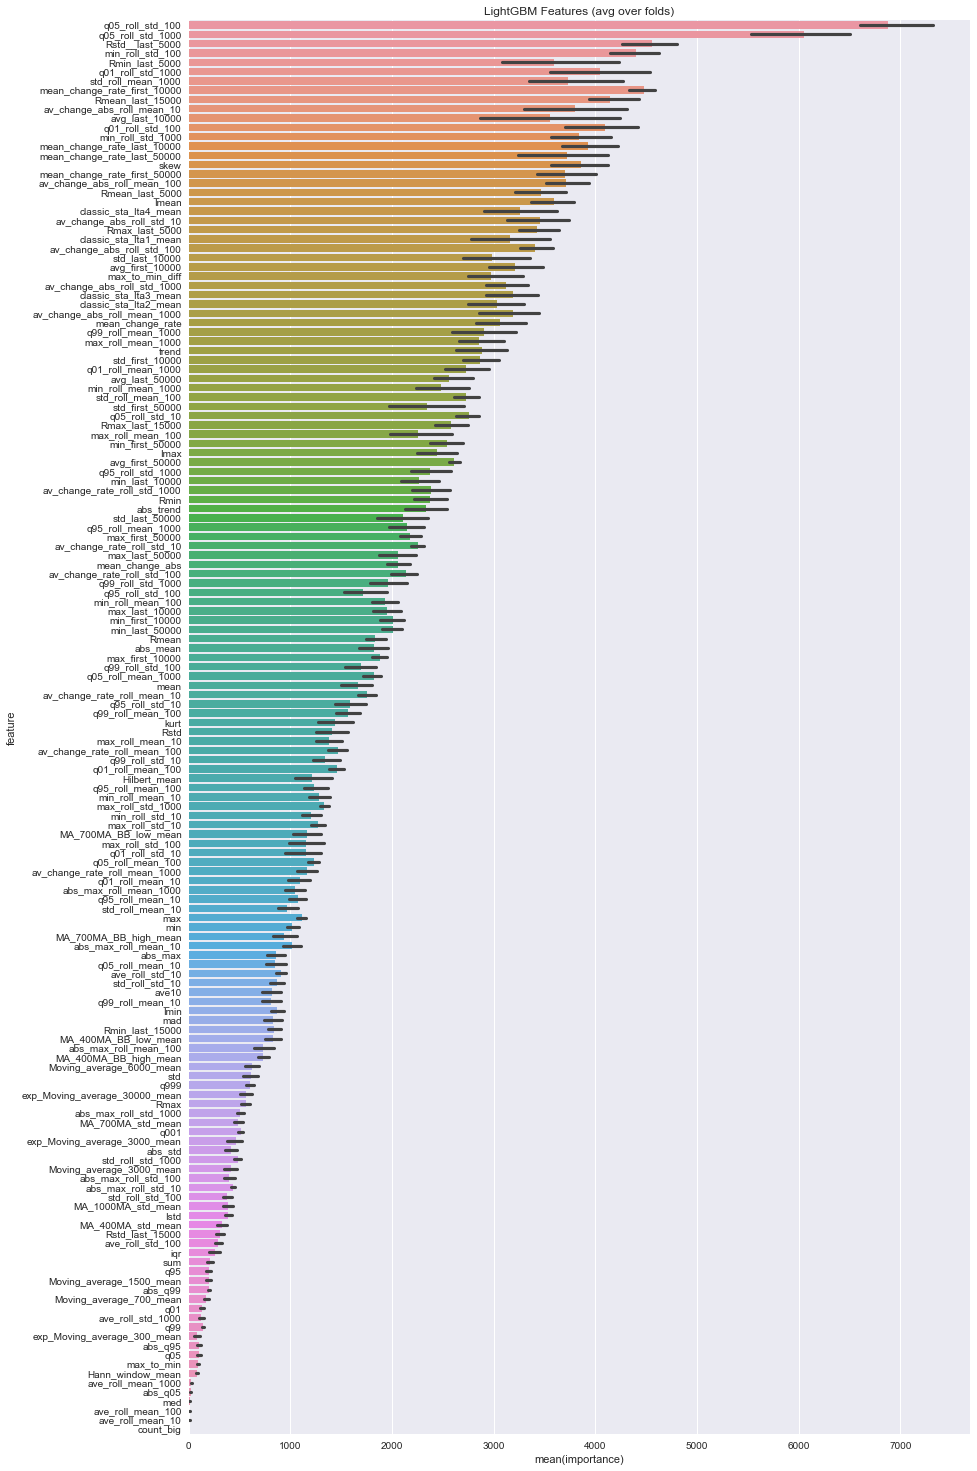

In [27]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.show()

In [29]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission.time_to_failure = sub_preds
submission.to_csv('submission_xgb.csv',index=True)

In [30]:
top_cols = list( feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index)

In [ ]:
#  feature selection: 120, 100, 80, 60

In [31]:
# Taking less columns 
scaled_train_X1 = scaled_train_X[top_cols]
scaled_test_X1 = scaled_test_X[top_cols]

In [32]:
dtrain1 = xgb.DMatrix(scaled_train_X1, label=train_y)
dtest1 = xgb.DMatrix(scaled_test_X1)

In [35]:
def xgb_evaluate(max_depth, subsample,gamma, colsample_bytree, max_leaves,max_bin, min_child_weight,colsample_bylevel,\
                reg_alpha,reg_lambda):
    params = {'eval_metric': 'rmse',\
              'objective': 'reg:linear',\
              'booster':'gbtree',\
              'max_depth': int(max_depth),\
              'subsample': subsample,\
              'eta': 0.03,\
              'gamma': gamma,\
              'colsample_bytree': colsample_bytree,\
             'max_leaves': int(max_leaves),\
              'max_bin':int(max_bin),\
              'min_child_weight':min_child_weight,\
              'colsample_bylevel':colsample_bylevel,\
              'reg_alpha':reg_alpha,\
              'reg_lambda':reg_lambda}
    cv_result = xgb.cv(params, dtrain1, num_boost_round=20000, nfold=5)    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [36]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (-1, 8), \
                                             'gamma': (0, 1),\
                                             'subsample': (0.6, 1.0),\
                                            'max_leaves': (20, 80),\
                                            'colsample_bytree': (0.6, 1.0),\
                                            'reg_lambda': (0, 1),\
                                            'reg_alpha': (0, 1),\
                                            'max_bin':(180,500),\
                                            'colsample_bylevel':(0.6,1.0),\
                                            'min_child_weight': (3, 20)})
# Use the expected improvement acquisition function to handle negative numbers
xgb_bo.maximize(init_points=2, n_iter=8, acq='ei')

Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bylevel |   colsample_bytree |     gamma |   max_bin |   max_depth |   max_leaves |   min_child_weight |   reg_alpha |   reg_lambda |   subsample | 
    1 | 12m11s |   -2.79875 |              0.8921 |             0.6052 |    0.8466 |  194.5717 |      4.6760 |      33.2518 |            10.1880 |      0.4999 |       0.4013 |      0.9077 | 
    2 | 23m46s |   -2.77412 |              0.8732 |             0.9626 |    0.2707 |  206.7374 |      6.5689 |      60.6484 |            18.4070 |      0.2221 |       0.6665 |      0.8992 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   

In [38]:
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(scaled_train_X1.shape[0])
sub_preds = np.zeros(scaled_test_X1.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(scaled_train_X1, train_y)):
    dtrain = xgb.DMatrix(scaled_train_X1.iloc[train_idx],train_y.iloc[train_idx])
    dvalid = xgb.DMatrix(scaled_train_X1.iloc[valid_idx],train_y.iloc[valid_idx])
    valid_y=train_y.iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'mae',
              'objective': 'reg:linear',
              'booster':'gbtree',
              #'tree_method': 'auto',
              'nthread' : 4,
              'eta' : 0.001,
              'max_leaves': 28,
              'max_depth' : 8,
              'max_bin':   419,
              'min_child_weight' : 9.0734,
              'subsample': 0.8405,
              'colsample_bytree' : 0.6459,
              'colsample_bylevel' :0.9870 ,
              'reg_alpha' : 0.2392,
              'reg_lambda' : 0.7243,
              'gamma':0.4855}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 20000, watchlist, maximize=False, early_stopping_rounds = 500, verbose_eval=1000)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest1,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del model, dtrain, dvalid
    gc.collect()

[0]	train-mae:5.17029	valid-mae:5.32879
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[1000]	train-mae:2.31687	valid-mae:2.59878
[2000]	train-mae:1.48918	valid-mae:2.12716
[3000]	train-mae:1.24244	valid-mae:2.11185
Stopping. Best iteration:
[2632]	train-mae:1.3097	valid-mae:2.10932

[0]	train-mae:5.20215	valid-mae:5.20159
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[1000]	train-mae:2.32789	valid-mae:2.5614
[2000]	train-mae:1.50695	valid-mae:2.03405
[3000]	train-mae:1.26651	valid-mae:1.98808
Stopping. Best iteration:
[3136]	train-mae:1.24453	valid-mae:1.988

[0]	train-mae:5.18828	valid-mae:5.25709
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[1000]	train-mae:2.3125	valid-mae:2.61302
[2000]	train

In [39]:
print('Full mae %.6f' % mean_absolute_error(train_y, oof_preds))

Full mae 2.058507


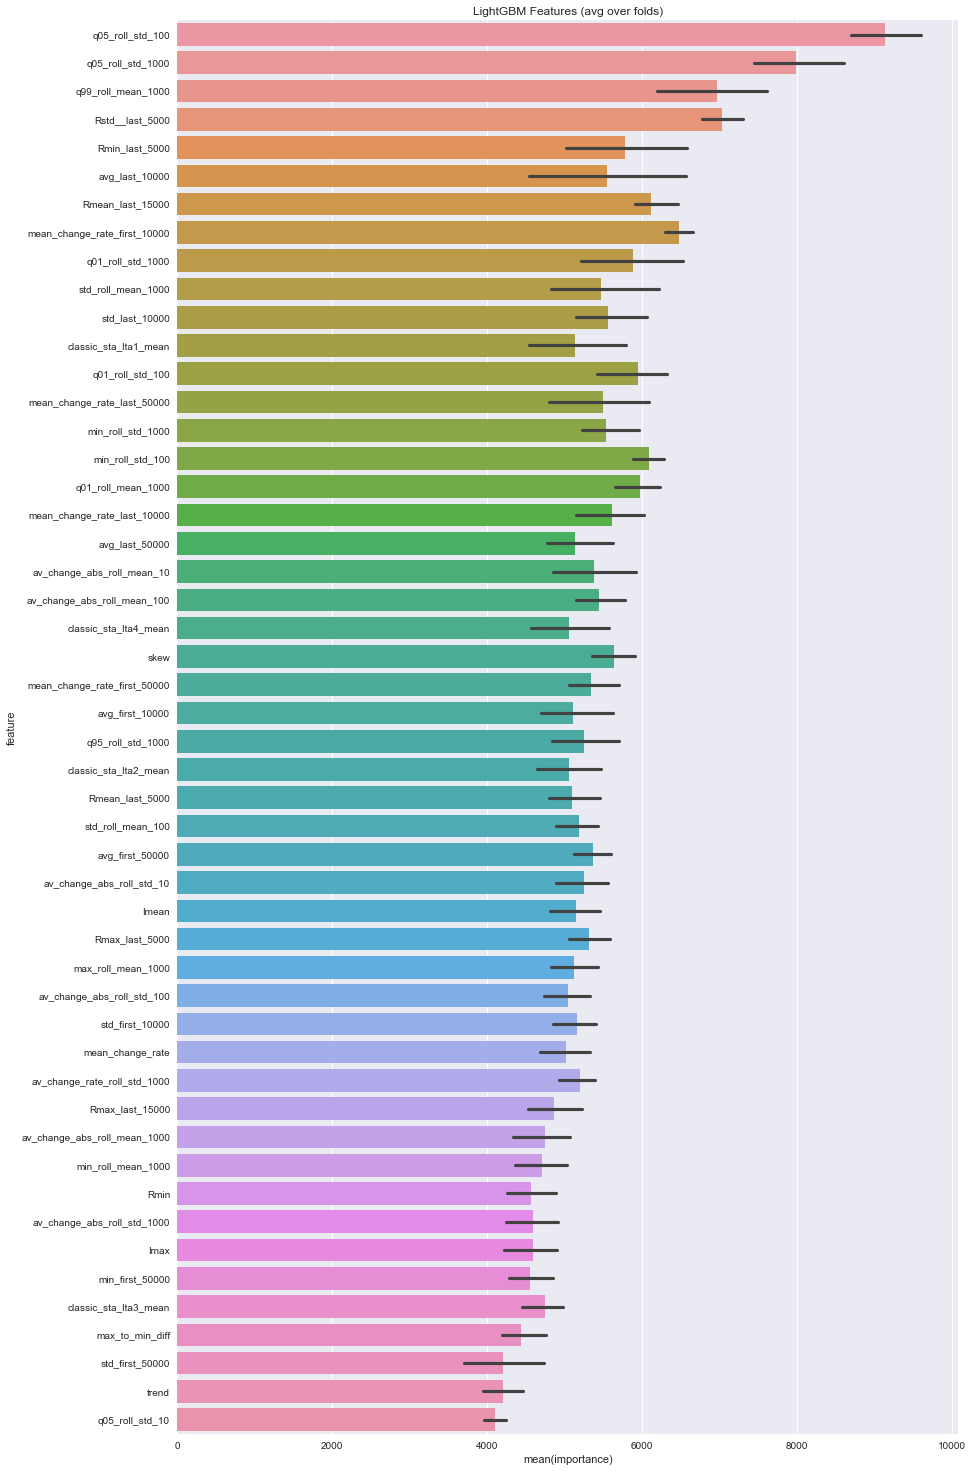

In [40]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.show()

In [41]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission.time_to_failure = sub_preds
submission.to_csv('submission_xgb2.csv',index=True)